# COMP47670 Assignment 2 - Peter Coogan (21202781)

In [2]:
import urllib.request
import bs4
import json

## TASK1: Data Collection

### Functions to fetch and parse data

In [2]:
def generate_url(main_URL, month, page_num):
    """Generates a url for the month and page number"""
    if page_num < 10:
        url = main_URL + "-" + month + "-00" + str(page_num) + ".html"
    else:
        url = main_URL + "-" + month + "-0" + str(page_num) + ".html"
    return url


def read_page(page_url, categories):
    """Reads a single web page for data"""
    
    # handle the request and gather html
    response = urllib.request.urlopen(page_url)
    html = response.read().decode()
    parser = bs4.BeautifulSoup(html, "html.parser")
    
    # find all articles
    articles = parser.find_all("div", {"class": "article"})
    
    dict_list = []
    # loop through the articles
    for article in articles:
        
        # the title of the article is the text in the <a tag
        title = (article.find("a").text)
        
        # the rest of the information is in the <p elements
        p_elems = article.find_all("p")
        
        # extract the category and snippet
        category, snippet = p_elems[1].text, p_elems[2].text
        
        # format the strings a little
        category = category.split(": ")[1] # gets rid of the word 'Category: ' in the string
        snippet = (snippet.replace(snippet[-2:], "")) # removes the ' ...' at the end of the snipppet
        
        # if the category is one of the three selected create a dictionary
        if category in categories:
             
            d = {"Title": title, "Category": category, "Snippet": snippet}
            dict_list.append(d) # append the dictionary to a list
        
    return dict_list


def read_data(main_URL, months, num_articles_lst, categories):
    """Reads all the data from the web pages"""
    
    data_list = [] # large dictionary to hold all data
    
    # for each month, get the data
    for month, num_articles in zip(months, num_articles_lst):
        
        # calculate the number of pages of articles for that month
        check = num_articles / 50
        if check.is_integer(): num_pages = check
        else: num_pages = (num_articles // 50) + 1
            
        # get data for each page
        for page_num in range(1, num_pages + 1):
            
            page_url = generate_url(main_URL, month, page_num) # generate the url
            page_dict_list = read_page(page_url, categories) # read the page
            
            # append data to dictionary with months as keys
            for d in page_dict_list:
                data_list.append(d)
                
    return data_list

def json_dump(file_name, data):
    """Format the data as json"""
    with open(file_name, 'w') as fp:
        json.dump(data, fp, indent=4)
    return

### Collect the data

In [3]:
months = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
num_articles_lst = [1522, 1492, 1395, 1209, 1315, 1376, 1358, 1254, 1347, 1395, 1343, 1220] # number of articles for each month
my_categories = ["US-News", "Sport", "Music"] # chosen article categories
main_url = "http://mlg.ucd.ie/modules/COMP41680/assignment2/month" # general url

data_list = read_data(main_url, months, num_articles_lst, my_categories) # list of dictionaries

In [4]:
json_dump("data.json", data_list) # convert the list of dictionaries to json format

## TASK2: Binary Text Classification

In [3]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
%matplotlib inline

### Functions to read the data and store it in a Pandas DataFrame

In [4]:
def read_json(file_name):
    """Read the json data"""
    with open(file_name) as fp:
        data = json.load(fp)
        
    return data

def generate_df(data_file):
    """Create a dataframe using the data"""
    raw_json = read_json(data_file) # read the data
    strings = []
    categories = []
    identifiers = []
    for article in raw_json:
        
        # concatenate the title and the snippet
        concatenated_str = article["Title"] + " " + article["Snippet"]
        strings.append(concatenated_str)
        
        category = article["Category"]
        categories.append(category)
        
        # assign an id to each category (might be used)
        if category == "Music":
            identifier = 0
        elif category == "US-News":
            identifier = 1
        else:
            identifier = 2
        identifiers.append(identifier)
    
    df = pd.DataFrame(data=[categories, strings, identifiers]).T
    df.columns = ["Category", "Title + Snippet", "id"]
    
    return df

In [5]:
data_df = generate_df("data.json")
data_df

,Category,Title + Snippet,id
0,Music,Mariah Carey's Twitter account hacked on New Y...,0
1,US-News,The final sprint: will any of the Democratic c...,1
2,Sport,Twenty athletes set to light up the Tokyo 2020...,2
3,Sport,Michael van Gerwen 3-7 Peter Wright: PDC world...,2
4,Music,Woodford folk festival review – a much-needed ...,0
...,...,...,...
5426,US-News,Joe Biden to have new Secret Service team amid...,1
5427,US-News,Joe Biden to hold national memorial service fo...,1
5428,Sport,Chess: Magnus Carlsen 'in a deep funk' after l...,2
5429,Sport,Toby Flood leading Newcastle revival in Jonny ...,2


The data is now in a Pandas DataFrame with identifier labels which will act as training and test targets

### Functions to filter the data, allocated train and test data and evaluate prediction accuracy

In [11]:
def filter_df(remove_category, df):
    """Filter a dataframe by removing a category"""
    filtered_df = df.drop(df[df.Category == remove_category].index)
    return filtered_df

def train_and_test_data(remove_category, data_df, frac):
    """generate training and test data from a filtered dataframe"""
    # filter the dataframe to the two categories selected
    filtered_df = filter_df(remove_category, data_df)
    # select a random 75% as the training data
    train_data_df = filtered_df.sample(frac=frac)
    train_docs = list(train_data_df["Title + Snippet"])
    train_target = list(train_data_df["id"])
    # select the other 25% as the test data
    test_data_df = filtered_df.drop(train_data_df.index)
    test_docs = list(test_data_df["Title + Snippet"])
    test_target = list(test_data_df["id"])
    # select the category names
    categories = list(filtered_df["Category"].unique())
    
    return (train_docs, train_target, test_docs, test_target, categories)
    
    
def train_and_test_model_accuracy(pipeline, train_docs, train_target, test_docs, test_target, categories):
    """Fit a model using a pipeline and print the accuracy"""
    pipeline.fit(train_docs, train_target)
    predicted = pipeline.predict(test_docs)
    print(f"Classifier accuracy for categories {categories} = {accuracy_score(test_target, predicted):.4f}")
    return test_target, predicted, categories

def confusion_matrix_plot(test_target, predicted, categories):
    """Plot the confusion matrix for a prediction"""
    cm = confusion_matrix(test_target, predicted)
    cmd = ConfusionMatrixDisplay(cm, display_labels=categories)
    cmd.plot()
    return

The data can now be filtered depending on the set of categories of interest. An example of a filtered dataframe is shown below

In [44]:
filtered = filter_df("Sport", data_df)
filtered

,Category,Title + Snippet,id
0,Music,Mariah Carey's Twitter account hacked on New Y...,0
1,US-News,The final sprint: will any of the Democratic c...,1
4,Music,Woodford folk festival review – a much-needed ...,0
5,Music,Tara Erraught/James Baillieu review – quietly ...,0
10,US-News,Detroit firefighters face backlash over photo ...,1
...,...,...,...
5424,US-News,What happened when California tried to fix its...,1
5425,US-News,First Thing: McConnell thwarts hopes of higher...,1
5426,US-News,Joe Biden to have new Secret Service team amid...,1
5427,US-News,Joe Biden to hold national memorial service fo...,1


### Generate training and test data for each of the category pairs

In this case, 75% of the data will be used from training and the other 25% will make up the test data.

In [45]:
train_and_test_music_and_news = train_and_test_data("Sport", data_df, frac=0.75) # music and news
train_and_test_music_and_sport = train_and_test_data("US-News", data_df, frac=0.75) # music and sport
train_and_test_news_and_sport = train_and_test_data("Music", data_df, frac=0.75) # news and sport

### Use a classification pipeline to streamline the process

Pipelines are useful in this case since they allow for the same set of actions to be applied to multiple sets of data.  
- Here we use built-in stop-words and filter out terms appearing in less than 5 documents
- We then transform this count matrix into a weighted matrix with TfidfTransformer
- Finally comes the classification step with the KNN classifier


In [6]:
pipeline1 = Pipeline([
    ('vec', CountVectorizer(stop_words="english", min_df=5)),
    ('tfidf', TfidfTransformer()),
    ('clf', KNeighborsClassifier(n_neighbors=3))
    
])

### Train the models, make predictions, display accuracy and plot confusion matrices for each pair

Classifier accuracy for categories ['Music', 'US-News'] = 0.9236


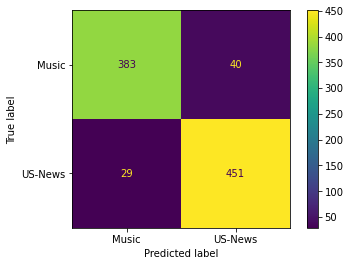

In [46]:
mn_test_target, mn_predicted, mn_cat = train_and_test_model_accuracy(pipeline1, *train_and_test_music_and_news)
confusion_matrix_plot(mn_test_target, mn_predicted, mn_cat)

Classifier accuracy for categories ['Music', 'Sport'] = 0.8993


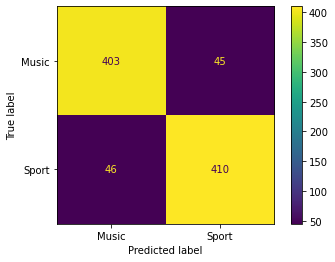

In [47]:
ms_test_target, ms_predicted, ms_cat = train_and_test_model_accuracy(pipeline1, *train_and_test_music_and_sport)
confusion_matrix_plot(ms_test_target, ms_predicted, ms_cat)

Classifier accuracy for categories ['US-News', 'Sport'] = 0.9306


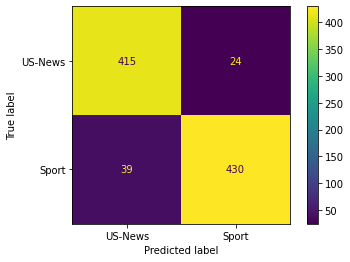

In [48]:
ns_test_target, ns_predicted, ns_cat = train_and_test_model_accuracy(pipeline1, *train_and_test_news_and_sport)
confusion_matrix_plot(ns_test_target, ns_predicted, ns_cat)

For the three cases above we have used 75% of the documents for training and 25% for testing. We have also implemented a KNN classifier with N=3. This has shown accuracies around 90% in all cases. The confusion matrices then show the numbers of correctly and incorrectly predicted labels for each category pair. The comparison of US-News and Sport seems to give a narrowly higher accuracy than the other two while the opposite is true for the Music and Sport comparison.

### Test out a different classifier

In this pipeline, a linear Support Vector Machine (SVN) classifier is used.

In [18]:
from sklearn.linear_model import SGDClassifier
pipeline2 = Pipeline([
    ('vec', CountVectorizer(stop_words="english", min_df=5)),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier())
    
])

Classifier accuracy for categories ['Music', 'US-News'] = 0.9513


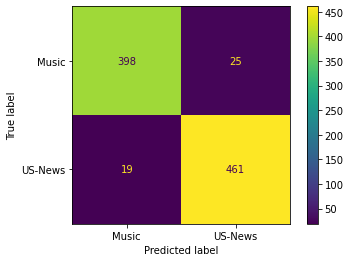

In [49]:
mn_test_target_sgd, mn_predicted_sgd, mn_cat_sgd = train_and_test_model_accuracy(pipeline2, *train_and_test_music_and_news)
confusion_matrix_plot(mn_test_target_sgd, mn_predicted_sgd, mn_cat_sgd)

Classifier accuracy for categories ['Music', 'Sport'] = 0.9569


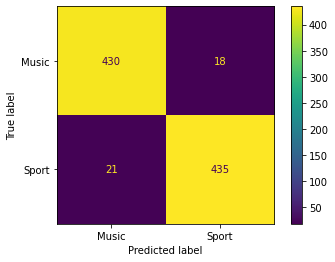

In [50]:
ms_test_target_sgd, ms_predicted_sgd, ms_cat_sgd = train_and_test_model_accuracy(pipeline2, *train_and_test_music_and_sport)
confusion_matrix_plot(ms_test_target_sgd, ms_predicted_sgd, ms_cat_sgd)

Classifier accuracy for categories ['US-News', 'Sport'] = 0.9615


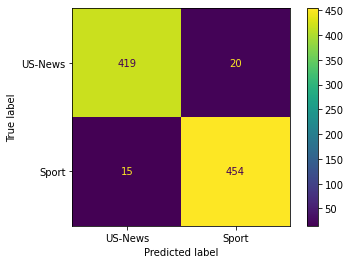

In [51]:
ns_test_target_sgd, ns_predicted_sgd, ns_cat_sgd = train_and_test_model_accuracy(pipeline2, *train_and_test_news_and_sport)
confusion_matrix_plot(ns_test_target_sgd, ns_predicted_sgd, ns_cat_sgd)

As can be seen from the above data, the SGD classifier does better at predicting the category and each of the binary comparisons results in an accuracy of around 95%.

### Investigate the effect of changing the percentage of training data

In this investigation, a number of different cases of training data fraction are tested and the accuracy scores when using the reamining test data are given for a KNN classifier with N=3.

Classifier accuracy for categories ['Music', 'US-News'] = 0.7318
Classifier accuracy for categories ['Music', 'Sport'] = 0.8387
Classifier accuracy for categories ['US-News', 'Sport'] = 0.8670
Classifier accuracy for categories ['Music', 'US-News'] = 0.8931
Classifier accuracy for categories ['Music', 'Sport'] = 0.8624
Classifier accuracy for categories ['US-News', 'Sport'] = 0.8940
Classifier accuracy for categories ['Music', 'US-News'] = 0.8979
Classifier accuracy for categories ['Music', 'Sport'] = 0.8771
Classifier accuracy for categories ['US-News', 'Sport'] = 0.9143
Classifier accuracy for categories ['Music', 'US-News'] = 0.9081
Classifier accuracy for categories ['Music', 'Sport'] = 0.8899
Classifier accuracy for categories ['US-News', 'Sport'] = 0.9301
Classifier accuracy for categories ['Music', 'US-News'] = 0.8927
Classifier accuracy for categories ['Music', 'Sport'] = 0.9004
Classifier accuracy for categories ['US-News', 'Sport'] = 0.9133
Classifier accuracy for categories 

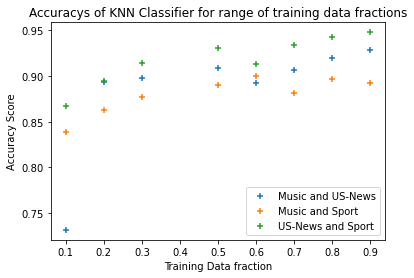

In [58]:
training_fracs = [0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9] # fractions of training data

accuracys_mn = []
accuracys_ms = []
accuracys_ns = []

# run the pipeline for different fractions of training and test data
for frac in training_fracs:
    
    music_and_news_tt = train_and_test_data("Sport", data_df, frac=frac) # music and news
    target_mn, predicted_mn, _ = train_and_test_model_accuracy(pipeline1, *music_and_news_tt)
    accuracy_mn = accuracy_score(target_mn, predicted_mn)
    accuracys_mn.append(accuracy_mn)
    
    music_and_sport_tt = train_and_test_data("US-News", data_df, frac=frac) # music and sport
    target_ms, predicted_ms, _ = train_and_test_model_accuracy(pipeline1, *music_and_sport_tt)
    accuracy_ms = accuracy_score(target_ms, predicted_ms)
    accuracys_ms.append(accuracy_ms)
    
    news_and_sport_tt = train_and_test_data("Music", data_df, frac=frac) # news and sport
    target_ns, predicted_ns, _ = train_and_test_model_accuracy(pipeline1, *news_and_sport_tt)
    accuracy_ns = accuracy_score(target_ns, predicted_ns)
    accuracys_ns.append(accuracy_ns)

# make the plot
acc_fig, acc_ax = plt.subplots()

acc_ax.set_title("Accuracys of KNN Classifier for range of training data fractions")
acc_ax.set_xlabel("Training Data fraction")
acc_ax.set_ylabel("Accuracy Score")

acc_ax.scatter(training_fracs, accuracys_mn, marker='+', label="Music and US-News")
acc_ax.scatter(training_fracs, accuracys_ms, marker='+', label="Music and Sport")
acc_ax.scatter(training_fracs, accuracys_ns, marker='+', label="US-News and Sport")

acc_ax.legend()

This plot shows that the larger then training data set, the more accurate the predictions are. This plot also indicates the trend that us-news and sport are easiest for the model to distinguish and music and sport are the most difficult to distinguish.

## TASK3: Multi-class Text Classification

The methods used for the binary classification task can  be very easily extended to the multi-class case. We do not need to write much more code in terms of data processing since we are just applying the same classification steps to the entire set of data instead of 2/3rds of it.

### Function to generate train and test data

The accuracy, prediction and confusion matrix functions defined above for the binary case will be reused.

In [7]:
def train_and_test_data_multi(data_df, frac):
    """generate training and test data from a dataframe"""
    # select a random 75% as the training data
    train_data_df = data_df.sample(frac=frac)
    train_docs = list(train_data_df["Title + Snippet"])
    train_target = list(train_data_df["id"])
    # select the other 25% as the test data
    test_data_df = data_df.drop(train_data_df.index)
    test_docs = list(test_data_df["Title + Snippet"])
    test_target = list(test_data_df["id"])
    # select the category names
    categories = list(data_df["Category"].unique())
    
    return (train_docs, train_target, test_docs, test_target, categories)

### Generate the training and test data and targets

In [8]:
train_and_test = train_and_test_data_multi(data_df, frac=0.75)

### Define a pipeline

In [20]:
pipeline_multi = Pipeline([
    ('vec', CountVectorizer(stop_words="english", min_df=5)),
    ('tfidf', TfidfTransformer()),
    ('clf', KNeighborsClassifier(n_neighbors=7))
    
])

### Train, test and evaluate

Classifier accuracy for categories ['Music', 'US-News', 'Sport'] = 0.8822
Precision Scores:
Music: 0.8454545454545455
US-News: 0.8719512195121951
Sport: 0.931924882629108


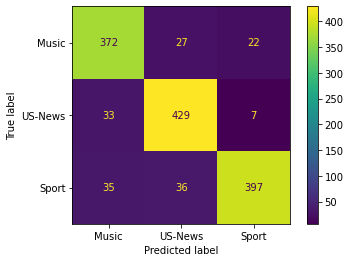

In [21]:
test_target_multi, predicted_multi, categories_multi = train_and_test_model_accuracy(pipeline_multi, *train_and_test)
confusion_matrix_plot(test_target_multi, predicted_multi, categories_multi)
precision_scores = precision_score(test_target_multi, predicted_multi, average=None)

print(f"Precision Scores:")
for i, score in enumerate(precision_scores):
    print(f"{categories_multi[i]}: {score}")

We can see that a KNN model with N=7 gives an accuracy of around 88% although this will vary slightly depending on the random selection of training and test data. We can see from the precision scores that the classifier performes best when classifying sport and worst when classifying music.  
The confusuion matrix shows that when US-News is incorrectly predicted, the label given is mostly Music. In the cases of incorrect predictions for Sport and Music, the incorrect predictions are approximately evenly split between the other two labels.